In [1]:
!wget http://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz 
!wget http://mftp.mmcheng.net/liuyun/rcf/data/PASCAL.tar.gz 
!wget http://mftp.mmcheng.net/liuyun/rcf/data/NYUD.tar.gz 

--2025-04-27 15:25:07--  http://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz
Resolving mftp.mmcheng.net (mftp.mmcheng.net)... 108.179.200.15
Connecting to mftp.mmcheng.net (mftp.mmcheng.net)|108.179.200.15|:80... 108.179.200.15
Connecting to mftp.mmcheng.net (mftp.mmcheng.net)|108.179.200.15|:80... connected.
HTTP request sent, awaiting response... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz [following]
--2025-04-27 15:25:08--  https://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz
Connecting to mftp.mmcheng.net (mftp.mmcheng.net)|108.179.200.15|:443... 301 Moved Permanently
Location: https://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz [following]
--2025-04-27 15:25:08--  https://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz
Connecting to mftp.mmcheng.net (mftp.mmcheng.net)|108.179.200.15|:443... connected.
connected.
HTTP request sent, awaiting response... HTTP request sent, a

In [2]:
!mkdir /notebooks/pidinet_data
!mkdir /notebooks/pidinet_data/BSDS500
%cd /notebooks/pidinet_data/BSDS500
!tar -xf /notebooks/HED-BSDS.tar.gz -C /notebooks/pidinet_data/BSDS500/
!tar -xf /notebooks/PASCAL.tar.gz -C /notebooks/pidinet_data/BSDS500/

!tar -xf /notebooks/BSDS500_val.tar.gz -C /notebooks/pidinet_data/BSDS500/HED-BSDS/

!cp /notebooks/data/BSDS500/HED-BSDS/*.lst /notebooks/pidinet_data/BSDS500
!cp /notebooks/data/BSDS500/*.lst /notebooks/pidinet_data/BSDS500/

mkdir: cannot create directory ‘/notebooks/pidinet_data’: File exists
mkdir: cannot create directory ‘/notebooks/pidinet_data/BSDS500’: File exists
mkdir: cannot create directory ‘/notebooks/pidinet_data/BSDS500’: File exists
/notebooks/pidinet_data/BSDS500
/notebooks/pidinet_data/BSDS500


# Simplified Keras/QKeras PiDiNet for hls4ml

**Objective:** Build, train (float and quantized), and prepare a simplified Keras PiDiNet for hls4ml synthesis.

**Motivation:** The original PyTorch PiDiNet implementation uses custom Pixel Difference Convolution (PDC) operations that are not directly supported by standard deep learning frameworks like Keras or quantization toolkits like QKeras, nor by hardware synthesis tools like hls4ml. To deploy PiDiNet on FPGAs using hls4ml, we need a version representable with standard layers.

**PiDiNet Philosophy:** The original PiDiNet workflow involves training a model with PDC operators and then *converting* the learned weights into equivalent standard convolutional kernels before deployment. This conversion captures the edge-detection properties learned by the PDC operators within standard convolution weights.

**Keras/hls4ml Approach:** Due to framework limitations (lack of direct PDC support in Keras/QKeras, hls4ml compatibility), we will adopt a slightly different approach. Instead of training with PDC and then converting, we will **build the Keras/QKeras models directly using the target vanilla CNN structure**. The conversion logic from the original PDC types (cv, cd, ad, rd) will be incorporated by choosing the appropriate `kernel_size` and `padding` for standard `Conv2D`/`QConv2D` layers during the model definition phase. This effectively pre-converts the *architecture* to its standard CNN equivalent before training.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import qkeras
from qkeras import QConv2D, QActivation, QDense, quantized_bits
import hls4ml
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow_datasets as tfds # Example dataset loader

print(f"TensorFlow version: {tf.__version__}")
print(f"QKeras version: {qkeras.__version__}")
print(f"hls4ml version: {hls4ml.__version__}")

# Configure GPU (optional)
# IMPORTANT: After installing/changing TensorFlow version (e.g., downgrading),
# re-run this cell and carefully check its output to ensure the GPU is still detected.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configure memory growth (good practice)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        # Check if GPUs were found
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU detected. Check TensorFlow installation and CUDA compatibility.")
    print("Note: QKeras training in Cell 6 requires a GPU due to grouped convolutions.")

2025-04-27 17:37:26.924028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 17:37:26.924076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 17:37:26.924104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 17:37:26.937766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.14.0
QKeras version: 0.9.0
hls4ml version: 1.1.0
1 Physical GPUs, 1 Logical GPUs


2025-04-27 17:37:32.042252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 17:37:32.097518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 17:37:32.097698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Cell 2: Define Keras PiDiNet Architecture (Vanilla Structure)

This model uses standard Keras layers (`Conv2D`, `BatchNormalization`, etc.). The key is that the parameters for the depthwise-like `Conv2D` layers (kernel size, padding) are chosen based on the *original* PDC type they represent, effectively building the converted structure directly.

In [2]:
# --- Constants ---
NUM_STAGES = 2 # Simplified example
BLOCKS_PER_STAGE = 2 # Simplified example
INITIAL_FILTERS = 16 # Corresponds to 'C' in PiDiNet paper for micro/tiny
DIL_FACTOR = 4 # Example dilation factor if CDCM were used
USE_SA = True # Example flag for CSAM
USE_DIL = True # Example flag for CDCM

# Simplified PDC config list for 2 stages, 2 blocks each + init_block
# Example: ['cd', 'cd', 'cd', 'ad', 'ad'] # init + 2*2 blocks
PDC_CONFIG = ['cd', 'cd', 'cd', 'ad', 'ad']
INPUT_SHAPE = (128, 128, 3) # Example input shape
NUM_CLASSES = 1 # For edge detection (binary) - Adjusted for edge map labels

# --- Helper Function: Get Standard Conv Params from PDC Type ---
def get_pdc_params(original_pdc_type):
    """Maps original PDC type to kernel_size/padding for standard Conv2D."""
    if original_pdc_type == 'rd':
        return {'kernel_size': 5, 'padding': 'same'}
    elif original_pdc_type in ['cv', 'cd', 'ad']:
        return {'kernel_size': 3, 'padding': 'same'}
    else:
        raise ValueError(f"Unknown PDC type: {original_pdc_type}")

# --- Keras PDC Block (Converted Structure) ---
def PDCBlock_converted_keras(x, original_pdc_type, inplane, ouplane, stride=1):
    """Implements the PDC block using standard Keras layers."""
    identity = x

    # Shortcut connection
    if stride > 1:
        x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
        identity = layers.Conv2D(ouplane, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    elif inplane != ouplane:
        identity = layers.Conv2D(ouplane, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    # else: identity remains x (stride=1, same channels)

    # Main path
    pdc_params = get_pdc_params(original_pdc_type)
    # Depthwise-like conv based on PDC type
    y = layers.Conv2D(inplane, # Depthwise uses input channels
                       kernel_size=pdc_params['kernel_size'],
                       strides=1, # Stride applied in MaxPool
                       padding=pdc_params['padding'],
                       groups=inplane, # Simulate depthwise
                       use_bias=False)(x)
    # Note: Original PiDiNet might have BN/ReLU here, simplified for clarity
    y = layers.ReLU()(y)
    # Pointwise conv
    y = layers.Conv2D(ouplane, kernel_size=1, strides=1, padding='same', use_bias=False)(y)
    # Note: Original PiDiNet might have BN/ReLU here too

    # Residual connection
    out = layers.add([identity, y])
    # Optional: Add final ReLU/BN if needed
    # out = layers.ReLU()(out)
    return out

# --- Define Simplified Keras PiDiNet Model ---
def build_simplified_keras_pidinet(input_shape, pdc_config, initial_filters, num_stages, blocks_per_stage, num_classes):
    x_in = layers.Input(shape=input_shape)
    pdc_idx = 0

    # Initial Block
    init_pdc_type = pdc_config[pdc_idx]
    pdc_params = get_pdc_params(init_pdc_type)
    x = layers.Conv2D(initial_filters,
                      kernel_size=pdc_params['kernel_size'],
                      strides=1,
                      padding=pdc_params['padding'],
                      use_bias=False)(x_in)
    # x = layers.BatchNormalization()(x) # Add BN/ReLU if mimicking full structure
    # x = layers.ReLU()(x)
    pdc_idx += 1

    current_filters = initial_filters
    stage_outputs = []

    # Stages and Blocks
    for stage in range(num_stages):
        for block in range(blocks_per_stage):
            stride = 2 if stage > 0 and block == 0 else 1
            output_filters = current_filters * 2 if stride > 1 else current_filters
            
            if pdc_idx >= len(pdc_config):
                 raise IndexError(f"PDC config list too short. Need at least {pdc_idx+1} entries.")
            
            x = PDCBlock_converted_keras(x, pdc_config[pdc_idx], current_filters, output_filters, stride)
            current_filters = output_filters
            pdc_idx += 1
        stage_outputs.append(x)

    # Fusion Layers (Simplified Example)
    fused_outputs = []
    target_h, target_w = input_shape[0], input_shape[1]

    for i, stage_out in enumerate(stage_outputs):
        # Simplified: Reduce channels to NUM_CLASSES (1), then upsample
        # In full PiDiNet, CDCM/CSAM might be here
        reduced = layers.Conv2D(NUM_CLASSES, kernel_size=1, padding='same', use_bias=False, name=f'reduce_{i}')(stage_out)
        
        # Upsample to original input size
        # Check if upsampling is needed
        _, h, w, _ = reduced.shape
        if h != target_h or w != target_w:
             upsampled = layers.UpSampling2D(size=(target_h // h, target_w // w), interpolation='bilinear', name=f'upsample_{i}')(reduced)
        else:
             upsampled = reduced
        fused_outputs.append(upsampled)

    # Concatenate side outputs
    if len(fused_outputs) > 1:
        concatenated = layers.Concatenate(axis=-1)(fused_outputs)
    else:
        concatenated = fused_outputs[0]

    # Final Classifier
    output = layers.Conv2D(num_classes, kernel_size=1, padding='same', use_bias=False, name='classifier')(concatenated)
    output = layers.Activation('sigmoid', name='output_sigmoid')(output)

    model = models.Model(inputs=x_in, outputs=output, name='simplified_keras_pidinet')
    return model

# --- Instantiate and Verify ---
keras_model = build_simplified_keras_pidinet(INPUT_SHAPE, PDC_CONFIG, INITIAL_FILTERS, NUM_STAGES, BLOCKS_PER_STAGE, NUM_CLASSES)
keras_model.summary()

# Verify layer sizes (optional but recommended)
print("\nChecking Layer Sizes (Trainable Parameters):")
for layer in keras_model.layers:
    if layer.count_params() > 0:
        layersize = layer.count_params()
        print(f"{layer.name}: {layersize}")
        # Example check for hls4ml latency strategy limit
        # Note: This check is approximate. Actual hls4ml limits depend on specific layer types and configurations.
        # The 4096 limit often applies to weights * activations product in dense/conv.
        # Parameter count is a rough proxy.
        if layersize > 4096*10: # Using a larger proxy limit for parameter count
            print(f"  WARNING: Layer {layer.name} might be large ({layersize} params) for hls4ml 'Latency' strategy.")

Model: "simplified_keras_pidinet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         432       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         144       ['conv2d[0][0]']              
                                                                                                  
 re_lu (ReLU)                (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
                                                                           

## Cell 3: Data Loading and Preprocessing

Load the BSDS500 dataset using the PyTorch `edge_dataloader.py` script and wrap it with `tf.data.Dataset.from_generator`.

In [3]:
# --- Data Loading Parameters ---
BATCH_SIZE = 16
BUFFER_SIZE = 1000 # For shuffling (less relevant when using from_generator with pre-shuffled loader)
IMG_HEIGHT = INPUT_SHAPE[0]
IMG_WIDTH = INPUT_SHAPE[1]
# NUM_CLASSES is defined in Cell 2 as 1
DATASET_ROOT = '/notebooks/pidinet_data/BSDS500/HED-BSDS/' # Adjust if your path differs

# --- Import PyTorch and Loader ---
import torch
from torch.utils.data import DataLoader as PyTorchDataLoader
from edge_dataloader import BSDS_Loader, custom_collate_fn # Assuming edge_dataloader.py is accessible
import tensorflow as tf
import tensorflow.keras.backend as K # Use Keras backend for some ops

import numpy as np # Ensure numpy is imported

# --- PyTorch DataLoader Generator for TensorFlow ---
def pytorch_dataloader_generator(pytorch_loader):
    """Generator that yields NumPy batches from a PyTorch DataLoader."""
    for img_batch, label_batch in pytorch_loader:
        # Convert images to NumPy and transpose
        img_np = img_batch.numpy()
        img_np = np.transpose(img_np, (0, 2, 3, 1))

        # Check if label_batch is a tensor (training) or list (validation/test)
        if isinstance(label_batch, torch.Tensor):
            # Training case: Convert labels to NumPy and transpose
            label_np = label_batch.numpy()
            label_np = np.transpose(label_np, (0, 2, 3, 1))
            # Ensure label is float32 (model output is sigmoid)
            label_np = label_np.astype(np.float32)
        else:
            # Validation/Testing case: label_batch is a list of names.
            # Keras validation requires a label tensor. Create a dummy one.
            # Use the shape from the image batch, but with 1 channel.
            batch_size = img_np.shape[0]
            h, w = img_np.shape[1], img_np.shape[2]
            # Create a dummy label tensor filled with zeros, matching the output_signature dtype.
            # Note: Validation metrics calculated using these dummy labels will not be meaningful.
            label_np = np.zeros((batch_size, h, w, 1), dtype=np.float32)

        yield img_np, label_np

# --- Custom Loss Function (RCF-style) ---
def cross_entropy_loss_RCF_tf(y_true, y_pred, beta=1.1): # Use standard Keras signature
    """
    TensorFlow implementation of the RCF weighted cross-entropy loss.

    Args:
        y_true: Ground truth labels (tf.Tensor, shape matching y_pred or broadcastable).
                Typically (batch, H, W) or (batch, H, W, 1).
                Values: 0: background, 1: edge, 2: ignore.
        y_pred: Predicted probabilities (tf.Tensor, float32, shape [batch, H, W, 1])
                or logits if from_logits=True.

    Returns:
        Scalar loss value (tf.Tensor, float32).
    """
    prediction = tf.convert_to_tensor(y_pred) # No dtype cast yet
    labelf = tf.convert_to_tensor(y_true)

    # Ensure prediction is float32 for calculations
    if prediction.dtype != tf.float32:
            prediction = tf.cast(prediction, tf.float32)

    # --- Shape Alignment ---
    # Ensure labelf has the same rank as prediction
    if len(prediction.shape) == len(labelf.shape) + 1:
        labelf = tf.expand_dims(labelf, axis=-1)
    elif len(labelf.shape) == len(prediction.shape) + 1:
            prediction = tf.expand_dims(prediction, axis=-1) # Less common but possible
    # If ranks still differ after potential expansion, raise error
    # Keras might handle some internal broadcasting, but explicit check is safer
    tf.assert_equal(tf.rank(prediction), tf.rank(labelf),
                    message=f"Prediction rank {tf.rank(prediction)} and Label rank {tf.rank(labelf)} must match after potential expansion.")


    # Cast label to integer for comparisons
    if labelf.dtype not in (tf.int32, tf.int64):
        label = tf.cast(labelf, tf.int32)
    else:
        label = labelf

    # Create boolean masks (shape should match prediction/labelf now)
    is_positive = tf.equal(label, 1)
    is_negative = tf.equal(label, 0)
    # print(f"Sum of positive pixels: {tf.reduce_sum(tf.cast(is_positive, tf.float32))}, Sum of negative pixels: {tf.reduce_sum(tf.cast(is_negative, tf.float32))}")
    is_valid = tf.logical_or(is_positive, is_negative) # Mask for valid pixels (0 or 1)

    # Count positive and negative samples ONLY within valid areas
    num_positive = tf.reduce_sum(tf.cast(is_positive, tf.float32))
    num_negative = tf.reduce_sum(tf.cast(tf.logical_and(is_negative, is_valid), tf.float32))

    # Calculate total relevant samples
    total_valid = num_positive + num_negative
    # Prevent division by zero if no valid positive/negative pixels in batch
    total_valid = tf.maximum(total_valid, 1e-6) # Avoid zero division

    # Calculate weights for positive and negative classes (Scalars)
    weight_positive = num_negative / total_valid
    weight_negative = beta * num_positive / total_valid

    # --- Explicit Weight Tensor Creation ---
    # Create tensors holding the weights, matching the prediction shape.
    # This makes broadcasting very explicit for the graph tracer.
    mask_shape = tf.shape(prediction)
    weights_tensor = tf.zeros(mask_shape, dtype=tf.float32) # Start with zeros (for ignore label 2)

    # Fill positive locations with positive weight
    weights_tensor = tf.where(is_positive,
                                tf.fill(mask_shape, weight_positive),
                                weights_tensor)

    # Fill negative locations with negative weight
    # Note: using tf.where sequentially like this is fine.
    weights_tensor = tf.where(is_negative,
                                tf.fill(mask_shape, weight_negative),
                                weights_tensor)
    
    # print(f"Weights tensor shape: {weights_tensor.shape}, Weights values: {weights_tensor.numpy()}")

    # Create binary targets (shape matches prediction)
    target = tf.cast(is_positive, tf.float32)

    # Compute binary cross entropy loss (element-wise)
    # Use Keras backend's BCE which might be more robust in graph mode
    bce = K.binary_crossentropy(target, prediction, from_logits=False)
    # print(f"Binary Cross-Entropy shape: {bce.shape}, BCE values: {bce.numpy()}")

    # Apply the calculated weights element-wise
    # bce and weights_tensor should now have guaranteed compatible shapes
    weighted_bce = bce * weights_tensor

    # --- Loss Reduction ---
    # Sum weighted loss and normalize. Normalizing by batch size is common.
    # Alternatively, normalize by the number of valid pixels.
    cost = tf.reduce_sum(weighted_bce)
    batch_size = tf.cast(tf.shape(prediction)[0], tf.float32)
    batch_size = tf.maximum(batch_size, 1e-6) # Avoid division by zero for empty batch
    cost = cost / batch_size

    # print(f"Batch size: {batch_size}, Cost: {cost}")

    # Alternative normalization: by number of valid pixels
    # num_valid_pixels = tf.reduce_sum(tf.cast(is_valid, tf.float32))
    # cost = tf.reduce_sum(weighted_bce) / tf.maximum(num_valid_pixels, self.epsilon)

    return cost

# --- Instantiate PyTorch Loaders ---
print(f"Loading data from: {DATASET_ROOT}")
print(f"Target image size: ({IMG_HEIGHT}, {IMG_WIDTH})")

try:
    # Training set
    train_bsds_dataset_pytorch = BSDS_Loader(
        root=DATASET_ROOT,
        split='train',
        threshold=0.05,  # Lower threshold to get more edge pixels
        fixed_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    train_loader_pytorch = PyTorchDataLoader(
        train_bsds_dataset_pytorch,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=2 # Adjust based on your system
    )

    # Test set (using 'test' split from BSDS_Loader)
    # Note: BSDS500 doesn't have a standard validation set in this format.
    # We'll use the test set for both validation and final testing here.
    test_bsds_dataset_pytorch = BSDS_Loader(
        root=DATASET_ROOT,
        split='test',
        threshold=0.05,
        fixed_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    test_loader_pytorch = PyTorchDataLoader(
        test_bsds_dataset_pytorch,
        batch_size=BATCH_SIZE,
        shuffle=False, # No shuffling for test/val
        collate_fn=custom_collate_fn,
        num_workers=2
    )
except FileNotFoundError:
    print(f"ERROR: Dataset not found at {DATASET_ROOT}. Please ensure the dataset is downloaded and extracted correctly.")
    print("Skipping dataset creation.")
    train_loader_pytorch = None
    test_loader_pytorch = None

# --- Create TensorFlow Datasets from PyTorch Loaders ---
output_signature = (
    tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32), # Batch, H, W, C
    tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.float32)  # Batch, H, W, 1 (labels 0., 1., 2.)
)

if train_loader_pytorch:
    train_dataset = tf.data.Dataset.from_generator(
        lambda: pytorch_dataloader_generator(train_loader_pytorch),
        output_signature=output_signature
    )
    # No .batch() needed as PyTorch loader provides batches
    # No .shuffle() needed here if PyTorch loader shuffles
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    print(f"Train dataset created: {train_dataset.element_spec}")
else:
    train_dataset = None
    print("Train dataset creation skipped due to missing data.")

if test_loader_pytorch:
    # Use the same test loader for validation and testing
    val_dataset = tf.data.Dataset.from_generator(
        lambda: pytorch_dataloader_generator(test_loader_pytorch),
        output_signature=output_signature
    )
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    print(f"Validation dataset created: {val_dataset.element_spec}")

    test_dataset = tf.data.Dataset.from_generator(
        lambda: pytorch_dataloader_generator(test_loader_pytorch),
        output_signature=output_signature
    )
    # No .batch() needed
    print(f"Test dataset created: {test_dataset.element_spec}")
else:
    val_dataset = None
    test_dataset = None
    print("Validation/Test dataset creation skipped due to missing data.")

# --- Preprocessing Function (Minimal - mostly handled by PyTorch loader) ---
# def preprocess(image, label):
#     # Ensure correct dtypes if needed (generator should handle this)
#     image = tf.cast(image, tf.float32)
#     label = tf.cast(label, tf.float32)
#     return image, label

# If preprocess mapping was needed:
# train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Test the train dataset
if train_dataset:
    for img_batch, label_batch in train_dataset.take(1):
        print(f"Train batch shape: {img_batch.shape}, Label batch shape: {label_batch.shape}")
        # Check if the batch is empty
        if img_batch.shape == 0 or label_batch.shape == 0:
            print("ERROR: Empty batch detected.")
        else:
            print("Train batch is valid.")

Loading data from: /notebooks/pidinet_data/BSDS500/HED-BSDS/
Target image size: (128, 128)
Threshold for ground truth: 12.800000 on BSDS
Threshold for ground truth: 12.800000 on BSDS
Train dataset created: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
Validation dataset created: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
Test dataset created: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))
Train batch shape: (16, 128, 128, 3), Label batch shape: (16, 128, 128, 1)
Train batch is valid.
Train batch shape: (16, 128, 128, 3), Label batch shape: (16, 128, 128, 1)
Train batch is valid.


## Cell 4: Floating-Point Model Training


Training Keras float model...
Epoch 1/5
1800/1800 [==============================] - 169s 93ms/step - loss: 1880.0624 - accuracy: 0.6459 - val_loss: 0.0000e+00 - val_accuracy: 0.6100
Epoch 2/5
Epoch 2/5
1800/1800 [==============================] - 157s 87ms/step - loss: 1822.9661 - accuracy: 0.6545 - val_loss: 0.0000e+00 - val_accuracy: 0.6389
Epoch 3/5
Epoch 3/5
1800/1800 [==============================] - 154s 86ms/step - loss: 1792.2581 - accuracy: 0.6585 - val_loss: 0.0000e+00 - val_accuracy: 0.6739
Epoch 4/5
Epoch 4/5
1800/1800 [==============================] - 155s 86ms/step - loss: 1774.3577 - accuracy: 0.6606 - val_loss: 0.0000e+00 - val_accuracy: 0.6597
Epoch 5/5
1800/1800 [==============================] - 155s 86ms/step - loss: 1774.3577 - accuracy: 0.6606 - val_loss: 0.0000e+00 - val_accuracy: 0.6597
Epoch 5/5
1800/1800 [==============================] - 150s 83ms/step - loss: 1758.8461 - accuracy: 0.6622 - val_loss: 0.0000e+00 - val_accuracy: 0.6079


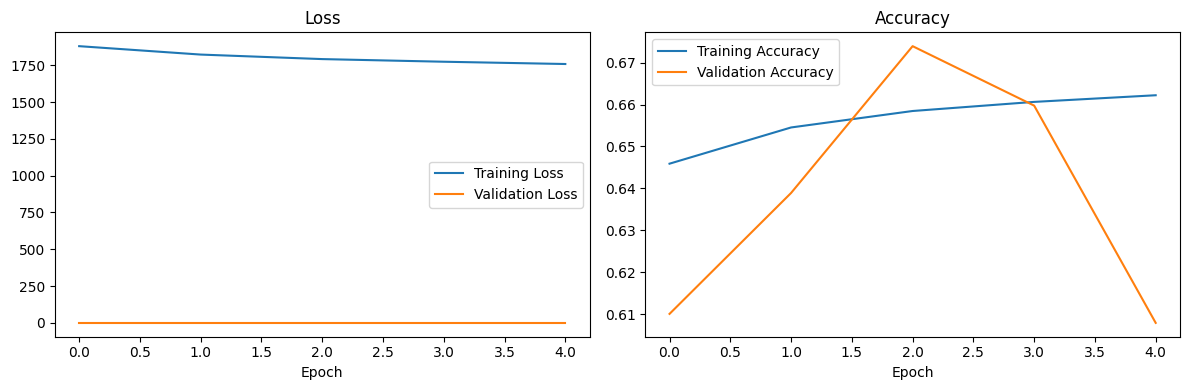

Saved Keras float model to simplified_pidinet_float.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# --- Training Parameters ---
EPOCHS = 5 # Use more epochs for real training
LEARNING_RATE = 0.001

# --- Compile and Train ---
# Use the custom RCF loss function defined in Cell 3
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    loss=cross_entropy_loss_RCF_tf,
                    metrics=['accuracy'], # Accuracy might still be misleading, consider IoU/F1 later
                    # run_eagerly=False) # Enable eager execution for debugging prints
                    run_eagerly=True) # Enable eager execution for debugging prints

print("\nTraining Keras float model...")
history = keras_model.fit(train_dataset,
                          epochs=EPOCHS,
                          validation_data=val_dataset)

# --- Plot History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# --- Save Model ---
keras_model.save('simplified_pidinet_float.h5')
print("Saved Keras float model to simplified_pidinet_float.h5")

## Cell 5: Define QKeras PiDiNet Architecture (Vanilla Structure)

This model mirrors the Keras float model structure but uses QKeras layers (`QConv2D`, `QActivation`). The `kernel_size` and `padding` for `QConv2D` are again determined by the original PDC type. We specify quantizers for weights and activations.

In [4]:
from qkeras import autoqkeras
# Removed incorrect import: from qkeras.qtools.quantized_operators import QuantAdd
# --- Quantizers ---
# Example: 6-bit weights, 6-bit activations
WEIGHT_QUANTIZER = "quantized_bits(6,0,alpha=1)"
ACT_QUANTIZER = "quantized_relu(6)" # ReLU activation
BIAS_QUANTIZER = "quantized_bits(6,0,alpha=1)" # If using bias
REQUANT_QUANTIZER = "quantized_bits(6)" # Generic quantizer for intermediate steps

# --- QKeras PDC Block (Converted Structure) ---
def QuantPDCBlock_keras(x, original_pdc_type, inplane, outplane, stride=1, weight_quantizer=None, act_quantizer=None, bias_quantizer=None):
    """Implements the PDC block using standard QKeras layers."""
    identity = x

    # Shortcut connection
    if stride > 1:
        x_pooled = layers.MaxPooling2D(pool_size=2, strides=2)(x) # Outputs float
        # Requantize after MaxPool before shortcut conv
        x_requant = QActivation(REQUANT_QUANTIZER, name=f'requant_pool_{x.name.split("/")[0]}')(x_pooled)
        identity = QConv2D(outplane, kernel_size=1, strides=1, padding='same',
                           kernel_quantizer=weight_quantizer,
                           bias_quantizer=bias_quantizer,
                           use_bias=False)(x_requant) # Use requantized input
        x = x_requant # Use requantized tensor for main path as well
    elif inplane != outplane:
        identity = QConv2D(outplane, kernel_size=1, strides=1, padding='same',
                           kernel_quantizer=weight_quantizer,
                           bias_quantizer=bias_quantizer,
                           use_bias=False)(x)
    # else: identity remains x (already QuantTensor or requantized)

    # Main path
    pdc_params = get_pdc_params(original_pdc_type)
    # Depthwise-like conv
    y = QConv2D(inplane,
                kernel_size=pdc_params['kernel_size'],
                strides=1,
                padding=pdc_params['padding'],
                groups=inplane,
                kernel_quantizer=weight_quantizer,
                bias_quantizer=bias_quantizer,
                use_bias=False)(x) # Input x is now always QuantTensor or requantized
    y = QActivation(act_quantizer)(y)
    # Pointwise conv
    y = QConv2D(outplane, kernel_size=1, strides=1, padding='same',
                kernel_quantizer=weight_quantizer,
                bias_quantizer=bias_quantizer,
                use_bias=False)(y)
    # Apply activation BEFORE residual add
    y_activated = QActivation(act_quantizer)(y)

    # Residual connection: Wrap standard add in QActivation
    # This ensures the output of the addition is immediately quantized
    out = QActivation(REQUANT_QUANTIZER, name=f'requant_add_{x.name.split("/")[0]}')(
        layers.add([identity, y_activated])
    )

    # Removed redundant QActivation that was previously here
    return out

# --- Define Simplified QKeras PiDiNet Model ---
def build_simplified_qkeras_pidinet(input_shape, pdc_config, initial_filters, num_stages, blocks_per_stage, num_classes,
                                    weight_quantizer, act_quantizer, bias_quantizer):
    x_in = layers.Input(shape=input_shape)
    pdc_idx = 0

    # Input Quantization (optional, depends on hls4ml config)
    # x = QActivation('quantized_bits(8,0)')(x_in)
    x = x_in # Assume input is float or handled by hls4ml

    # Initial Block
    init_pdc_type = pdc_config[pdc_idx]
    pdc_params = get_pdc_params(init_pdc_type)
    # Add input quantizer before first QConv2D if input is float
    x_quant_in = QActivation(REQUANT_QUANTIZER, name='quant_input')(x)
    x = QConv2D(initial_filters,
                kernel_size=pdc_params['kernel_size'],
                strides=1,
                padding=pdc_params['padding'],
                kernel_quantizer=weight_quantizer,
                bias_quantizer=bias_quantizer,
                use_bias=False)(x_quant_in)
    x = QActivation(act_quantizer)(x)
    pdc_idx += 1

    current_filters = initial_filters
    stage_outputs = []

    # Stages and Blocks
    for stage in range(num_stages):
        for block in range(blocks_per_stage):
            stride = 2 if stage > 0 and block == 0 else 1
            output_filters = current_filters * 2 if stride > 1 else current_filters

            if pdc_idx >= len(pdc_config):
                 raise IndexError(f"PDC config list too short. Need at least {pdc_idx+1} entries.")

            x = QuantPDCBlock_keras(x, pdc_config[pdc_idx], current_filters, output_filters, stride,
                                    weight_quantizer, act_quantizer, bias_quantizer)
            current_filters = output_filters
            pdc_idx += 1
        stage_outputs.append(x)

    # Fusion Layers (Simplified Example)
    fused_outputs_requant = []
    target_h, target_w = input_shape[0], input_shape[1]

    for i, stage_out in enumerate(stage_outputs):
        reduced = QConv2D(1, kernel_size=1, padding='same',
                          kernel_quantizer=weight_quantizer,
                          bias_quantizer=bias_quantizer,
                          use_bias=False, name=f'qreduce_{i}')(stage_out)

        # Upsample - standard Keras layer, output is float
        _, h, w, _ = reduced.shape
        if h != target_h or w != target_w:
             upsampled_float = layers.UpSampling2D(size=(target_h // h, target_w // w), interpolation='bilinear', name=f'upsample_{i}')(reduced)
        else:
             upsampled_float = reduced # Still a QuantTensor if not upsampled
        # Requantize after upsampling (or if not upsampled, ensure it's QuantTensor)
        upsampled_requant = QActivation(REQUANT_QUANTIZER, name=f'requant_upsample_{i}')(upsampled_float)
        fused_outputs_requant.append(upsampled_requant)

    # Concatenate side outputs (inputs are now QuantTensors)
    if len(fused_outputs_requant) > 1:
        # Concatenate might still output float if inputs have different scales
        concatenated_maybe_float = layers.Concatenate(axis=-1)(fused_outputs_requant)
    else:
        concatenated_maybe_float = fused_outputs_requant[0]

    # Requantize after Concatenate before classifier
    concatenated_requant = QActivation(REQUANT_QUANTIZER, name='requant_concat')(concatenated_maybe_float)

    # Final Classifier
    output = QConv2D(num_classes, kernel_size=1, padding='same',
                     kernel_quantizer=weight_quantizer,
                     bias_quantizer=bias_quantizer,
                     use_bias=False, name='qclassifier')(concatenated_requant) # Input is requantized
    # Final activation - Use QActivation sigmoid
    output = QActivation('quantized_sigmoid(6)', name='output_sigmoid')(output)

    model = models.Model(inputs=x_in, outputs=output, name='simplified_qkeras_pidinet')
    return model

# --- Instantiate and Verify ---
qkeras_model = build_simplified_qkeras_pidinet(INPUT_SHAPE, PDC_CONFIG, INITIAL_FILTERS, NUM_STAGES, BLOCKS_PER_STAGE, NUM_CLASSES,
                                             WEIGHT_QUANTIZER, ACT_QUANTIZER, BIAS_QUANTIZER)
qkeras_model.summary()

print("\nQKeras Model Quantization Summary:")
autoqkeras.utils.print_qmodel_summary(qkeras_model)

Model: "simplified_qkeras_pidinet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 quant_input (QActivation)   (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 q_conv2d (QConv2D)          (None, 128, 128, 16)         432       ['quant_input[0][0]']         
                                                                                                  
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connec

In [5]:
# --- Test Cell for QuantPDCBlock_keras ---
print("\n--- Testing QuantPDCBlock_keras in Isolation (Identity vs Main Path) ---")

# Check for GPU
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Test Parameters (remain the same)
test_batch_size = 2
test_h, test_w = 32, 32
test_in_channels = 16
test_out_channels_same = 16 # For stride=1, same channels
test_out_channels_diff = 32 # For stride=2, different channels
test_stride_1 = 1
test_stride_2 = 2
test_pdc_type = 'cd'

# Dummy Input Data (Float)
dummy_input_shape = (test_batch_size, test_h, test_w, test_in_channels)
dummy_input_data = tf.random.normal(dummy_input_shape)
print(f"Dummy Input Shape: {dummy_input_data.shape}")

# --- Test 1: Identity Path Only ---
print("\n--- Testing Identity Path Only ---")
# Case 1a: Stride = 1, Same Channels (Identity should be just input quantization)
input_tensor_id1a = layers.Input(shape=(test_h, test_w, test_in_channels))
quant_input_id1a = QActivation(REQUANT_QUANTIZER, name='id1a_quant_input')(input_tensor_id1a)
# In QuantPDCBlock, if stride=1 and channels same, identity = x (which is already quant)
# Replace qkeras.QuantizedIdentity with standard Keras Identity
identity_output_1a = layers.Identity(name='id1a_identity_passthrough')(quant_input_id1a)
test_model_identity_1a = models.Model(inputs=input_tensor_id1a, outputs=identity_output_1a, name='IdentityPath_S1_SameC')
# Use explicit shape for dummy labels
dummy_labels_1a_shape = (test_batch_size, test_h, test_w, test_in_channels)
dummy_labels_1a = tf.random.uniform(dummy_labels_1a_shape, minval=0, maxval=1)

# Case 1b: Stride = 1, Different Channels
input_tensor_id1b = layers.Input(shape=(test_h, test_w, test_in_channels))
quant_input_id1b = QActivation(REQUANT_QUANTIZER, name='id1b_quant_input')(input_tensor_id1b)
# Replace QConv2D with standard Conv2D for gradient check
identity_output_1b = layers.Conv2D(test_out_channels_diff, kernel_size=1, strides=1, padding='same',
                                  # kernel_quantizer=WEIGHT_QUANTIZER,
                                  # bias_quantizer=BIAS_QUANTIZER,
                                  use_bias=False, name='id1b_shortcut_conv')(quant_input_id1b)
test_model_identity_1b = models.Model(inputs=input_tensor_id1b, outputs=identity_output_1b, name='IdentityPath_S1_DiffC')
# Use explicit shape for dummy labels
dummy_labels_1b_shape = (test_batch_size, test_h, test_w, test_out_channels_diff)
dummy_labels_1b = tf.random.uniform(dummy_labels_1b_shape, minval=0, maxval=1)

# Case 1c: Stride = 2 (Implies Different Channels)
input_tensor_id1c = layers.Input(shape=(test_h, test_w, test_in_channels))
quant_input_id1c = QActivation(REQUANT_QUANTIZER, name='id1c_quant_input')(input_tensor_id1c)
x_pooled_id1c = layers.MaxPooling2D(pool_size=2, strides=2, name='id1c_pool')(quant_input_id1c)
x_requant_id1c = QActivation(REQUANT_QUANTIZER, name='id1c_requant_pool')(x_pooled_id1c)
# Replace QConv2D with standard Conv2D for gradient check
identity_output_1c = layers.Conv2D(test_out_channels_diff, kernel_size=1, strides=1, padding='same',
                                  # kernel_quantizer=WEIGHT_QUANTIZER,
                                  # bias_quantizer=BIAS_QUANTIZER,
                                  use_bias=False, name='id1c_shortcut_conv')(x_requant_id1c)
test_model_identity_1c = models.Model(inputs=input_tensor_id1c, outputs=identity_output_1c, name='IdentityPath_S2_DiffC')
# Use explicit shape for dummy labels (consider pooling effect)
dummy_labels_1c_shape = (test_batch_size, test_h // 2, test_w // 2, test_out_channels_diff)
dummy_labels_1c = tf.random.uniform(dummy_labels_1c_shape, minval=0, maxval=1)

# Function to run gradient check
def check_gradients(model_to_check, input_data, label_data, model_name):
    print(f"\n--- Gradient Check for: {model_name} ---")
    model_to_check.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', run_eagerly=True)
    with tf.GradientTape() as tape:
        predictions = model_to_check(input_data, training=True)
        loss = model_to_check.compiled_loss(label_data, predictions, regularization_losses=model_to_check.losses)
    print(f"Loss: {loss}")
    if loss is None or tf.math.is_nan(loss):
        print("Error: Loss is None or NaN.")
        return
    trainable_vars = model_to_check.trainable_variables
    if not trainable_vars:
        print("Warning: No trainable variables found.")
        return
    gradients = tape.gradient(loss, trainable_vars)
    print("Gradients:")
    all_none = True
    none_vars = []
    for var, grad in zip(trainable_vars, gradients):
        if grad is not None:
            print(f"  Var: {var.name}, Grad Shape: {grad.shape}")
            all_none = False
        else:
            print(f"  Var: {var.name}, Grad: None")
            none_vars.append(var.name)
    if all_none:
        print("Result: All gradients are None.")
    elif none_vars:
        print(f"Result: Some gradients are None: {none_vars}")
    else:
        print("Result: All gradients computed.")

# Run checks for identity paths
check_gradients(test_model_identity_1a, dummy_input_data, dummy_labels_1a, test_model_identity_1a.name)
check_gradients(test_model_identity_1b, dummy_input_data, dummy_labels_1b, test_model_identity_1b.name)
check_gradients(test_model_identity_1c, dummy_input_data, dummy_labels_1c, test_model_identity_1c.name)

# --- Test 2: Main Path Only ---
print("\n--- Testing Main Path Only ---")
pdc_params = get_pdc_params(test_pdc_type) # Use helper from Cell 2
input_tensor_main = layers.Input(shape=(test_h, test_w, test_in_channels))
quant_input_main = QActivation(REQUANT_QUANTIZER, name='main_quant_input')(input_tensor_main)
# Replace QConv2D with standard Conv2D for gradient check
y_main = layers.Conv2D(test_in_channels, kernel_size=1, strides=1, padding='same', # DEBUG 1x1
                      # groups=test_in_channels, # Grouped conv commented out
                      # kernel_quantizer=WEIGHT_QUANTIZER,
                      # bias_quantizer=BIAS_QUANTIZER,
                      use_bias=False, name='main_conv1')(quant_input_main)
y_main = QActivation(ACT_QUANTIZER, name='main_act1')(y_main)
# Replace QConv2D with standard Conv2D for gradient check
y_main = layers.Conv2D(test_out_channels_same, kernel_size=1, strides=1, padding='same',
                      # kernel_quantizer=WEIGHT_QUANTIZER,
                      # bias_quantizer=BIAS_QUANTIZER,
                      use_bias=False, name='main_conv2')(y_main)
main_path_output = QActivation(ACT_QUANTIZER, name='main_act2')(y_main)
test_model_main = models.Model(inputs=input_tensor_main, outputs=main_path_output, name='MainPath')
# Use explicit shape for dummy labels
dummy_labels_main_shape = (test_batch_size, test_h, test_w, test_out_channels_same)
dummy_labels_main = tf.random.uniform(dummy_labels_main_shape, minval=0, maxval=1)

# Run check for main path
check_gradients(test_model_main, dummy_input_data, dummy_labels_main, test_model_main.name)

print("\n--- Isolation Test Complete ---")


--- Testing QuantPDCBlock_keras in Isolation (Identity vs Main Path) ---
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dummy Input Shape: (2, 32, 32, 16)

--- Testing Identity Path Only ---

--- Gradient Check for: IdentityPath_S1_SameC ---

--- Gradient Check for: IdentityPath_S1_SameC ---


Loss: 0.8495368361473083

--- Gradient Check for: IdentityPath_S1_DiffC ---
Loss: 0.6489127278327942
Gradients:
  Var: id1b_shortcut_conv/kernel:0, Grad Shape: (1, 1, 16, 32)
Result: All gradients computed.

--- Gradient Check for: IdentityPath_S2_DiffC ---
Loss: 0.8986557126045227
Gradients:
  Var: id1c_shortcut_conv/kernel:0, Grad Shape: (1, 1, 16, 32)
Result: All gradients computed.

--- Testing Main Path Only ---


2025-04-27 17:37:38.665950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600



--- Gradient Check for: MainPath ---
Loss: 0.25066566467285156
Gradients:
  Var: main_conv1/kernel:0, Grad Shape: (1, 1, 16, 16)
  Var: main_conv2/kernel:0, Grad Shape: (1, 1, 16, 16)
Result: All gradients computed.

--- Isolation Test Complete ---
Loss: 0.25066566467285156
Gradients:
  Var: main_conv1/kernel:0, Grad Shape: (1, 1, 16, 16)
  Var: main_conv2/kernel:0, Grad Shape: (1, 1, 16, 16)
Result: All gradients computed.

--- Isolation Test Complete ---


## Cell 6: Quantization-Aware Training (QAT)

**Important Note:** Training this specific QKeras model requires a **GPU**. The `QuantPDCBlock_keras` uses `QConv2D` with `groups=inplane` to mimic depthwise convolutions. TensorFlow's CPU backend does not support gradient calculations for grouped convolutions, leading to an `InvalidArgumentError`. Ensure a GPU is available and configured correctly (as attempted in Cell 1) before running the training cell below.


Training QKeras model...
Epoch 1/5


2025-04-27 17:40:26.543407: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2857aa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-27 17:40:26.543619: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-04-27 17:40:26.550405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-27 17:40:26.642288: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1800/1800 [==============================] - 238s 130ms/step - loss: 2334.9167 - accuracy: 0.6093 - val_loss: 0.0000e+00 - val_accuracy: 0.6739
Epoch 2/5
1800/1800 [==============================] - 238s 130ms/step - loss: 2334.9167 - accuracy: 0.6093 - val_loss: 0.0000e+00 - val_accuracy: 0.6739
Epoch 2/5
1800/1800 [==============================] - 223s 124ms/step - loss: 2212.9219 - accuracy: 0.6237 - val_loss: 0.0000e+00 - val_accuracy: 0.6561
Epoch 3/5
1800/1800 [==============================] - 223s 124ms/step - loss: 2212.9219 - accuracy: 0.6237 - val_loss: 0.0000e+00 - val_accuracy: 0.6561
Epoch 3/5
1800/1800 [==============================] - 224s 124ms/step - loss: 2110.7014 - accuracy: 0.6275 - val_loss: 0.0000e+00 - val_accuracy: 0.6238
Epoch 4/5
1800/1800 [==============================] - 224s 124ms/step - loss: 2110.7014 - accuracy: 0.6275 - val_loss: 0.0000e+00 - val_accuracy: 0.6238
Epoch 4/5
1800/1800 [==============================] - 222s 123ms/step - loss: 2108.72

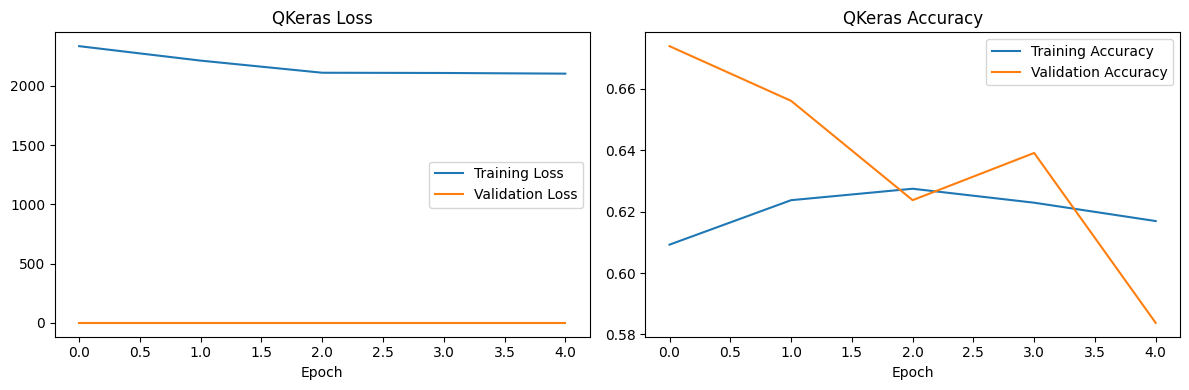

Saved QKeras model to simplified_pidinet_qkeras.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.11/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [7]:
# --- Compile and Train QKeras Model ---
EPOCHS = 5 # Use more epochs for real training
LEARNING_RATE = 0.001
# Use the custom RCF loss function defined in Cell 3
qkeras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss=cross_entropy_loss_RCF_tf,
                     metrics=['accuracy'],
                     run_eagerly=True) # Set run_eagerly=True if encountering graph mode issues

print("\nTraining QKeras model...")
# Check if GPU is available before training
if not tf.config.list_physical_devices('GPU'):
    print("\nWARNING: No GPU detected. QKeras training with grouped convolutions requires a GPU.")
    print("Skipping QKeras training.")
    # Optionally, load a pre-trained model or skip subsequent steps
    # qkeras_model = qkeras.utils.load_qmodel('path/to/pretrained_qkeras.h5')
else:
    q_history = qkeras_model.fit(train_dataset,
                               epochs=EPOCHS,
                               validation_data=val_dataset)

    # --- Plot History ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(q_history.history['loss'], label='Training Loss')
    plt.plot(q_history.history['val_loss'], label='Validation Loss')
    plt.title('QKeras Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(q_history.history['accuracy'], label='Training Accuracy')
    plt.plot(q_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('QKeras Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Save Model ---
    qkeras_model.save('simplified_pidinet_qkeras.h5')
    print("Saved QKeras model to simplified_pidinet_qkeras.h5")

## Cell 7: Model Evaluation


Loading models for evaluation...
Evaluating Keras float model...


2025-04-27 18:13:52.166700: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6091817497912136463
2025-04-27 18:13:52.166778: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10107900641350505675
2025-04-27 18:13:52.166799: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12038698020995996062


  Float Model - Loss: 0.0000, Accuracy: 0.6079
Evaluating QKeras model...
  QKeras Model - Loss: 0.0000, Accuracy: 0.5838

Visualizing predictions...


2025-04-27 18:13:53.442233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2978498164843308609
2025-04-27 18:13:53.442282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18310300512795691836
2025-04-27 18:13:53.442327: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7338913788664200812


1/1 [==============================] - 1s 628ms/step


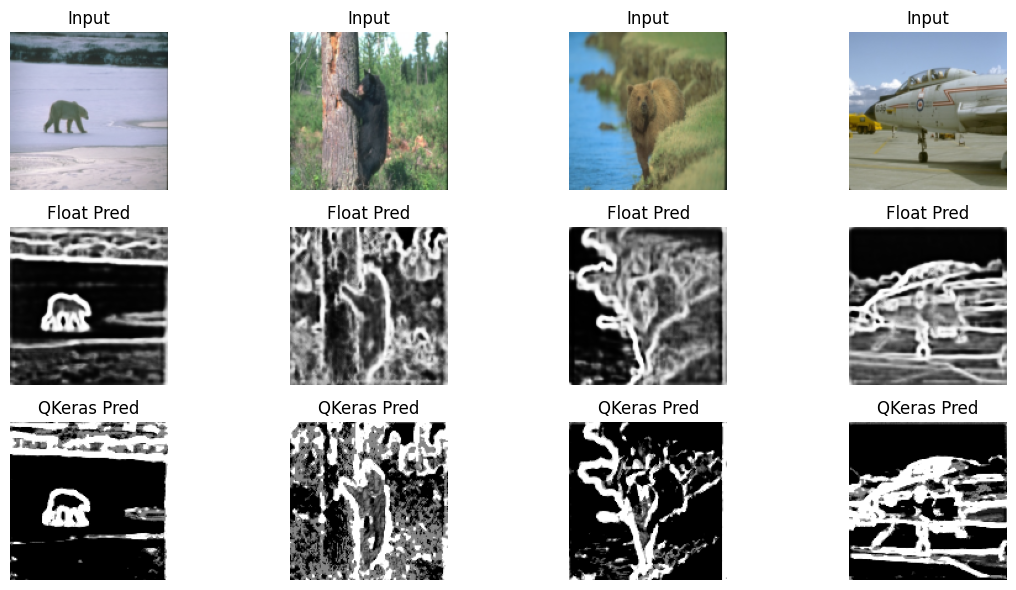

In [9]:
# --- Load Models ---
print("\nLoading models for evaluation...")
# Provide the custom loss function during loading
custom_objects = {'cross_entropy_loss_RCF_tf': cross_entropy_loss_RCF_tf}
loaded_keras_model = tf.keras.models.load_model('simplified_pidinet_float.h5', custom_objects=custom_objects)

# Need custom objects for QKeras layers - Use load_qmodel instead
# Also include the custom loss for qkeras loading
# qkeras.utils.load_qmodel internally calls tf.keras.models.load_model
loaded_qkeras_model = qkeras.utils.load_qmodel('simplified_pidinet_qkeras.h5', custom_objects=custom_objects)

print("Evaluating Keras float model...")
# Re-compile the loaded model if you want to use evaluate with the custom loss
# Or ensure compile=True (default) in load_model and the loss was saved correctly
# If compile=False was used during saving or loading, you need to compile manually:
# loaded_keras_model.compile(optimizer='adam', loss=cross_entropy_loss_RCF_tf, metrics=['accuracy'])
loss_float, acc_float = loaded_keras_model.evaluate(test_dataset, verbose=0)
print(f"  Float Model - Loss: {loss_float:.4f}, Accuracy: {acc_float:.4f}")

print("Evaluating QKeras model...")
# Evaluate the loaded QKeras model
# loaded_qkeras_model.compile(optimizer='adam', loss=cross_entropy_loss_RCF_tf, metrics=['accuracy'])
loss_q, acc_q = loaded_qkeras_model.evaluate(test_dataset, verbose=0)
print(f"  QKeras Model - Loss: {loss_q:.4f}, Accuracy: {acc_q:.4f}")

# --- Visualize Predictions (Example) ---
print("\nVisualizing predictions...")
# Ensure test_dataset yields images and dummy labels correctly
visualization_dataset = tf.data.Dataset.from_generator(
    lambda: pytorch_dataloader_generator(test_loader_pytorch),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

for images, _ in visualization_dataset.take(1): # We don't need the dummy labels here
    pred_float = loaded_keras_model.predict(images)
    pred_q = loaded_qkeras_model.predict(images)

    plt.figure(figsize=(12, 6))
    n_show = min(images.shape[0] if images.shape[0] is not None else BATCH_SIZE, 4)
    for i in range(n_show):
        # Original Image
        plt.subplot(3, n_show, i + 1)
        # Denormalize or adjust image range if necessary for display
        display_img = images[i].numpy() # Convert to numpy
        # Example denormalization (adjust mean/std if they were used)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        display_img = std * display_img + mean
        display_img = np.clip(display_img, 0, 1)
        plt.imshow(display_img)
        plt.title("Input")
        plt.axis('off')

        # Float Prediction
        plt.subplot(3, n_show, i + 1 + n_show)
        plt.imshow(pred_float[i][..., 0], cmap='gray') # Assuming single channel output
        plt.title("Float Pred")
        plt.axis('off')

        # QKeras Prediction
        plt.subplot(3, n_show, i + 1 + 2 * n_show)
        plt.imshow(pred_q[i][..., 0], cmap='gray')
        plt.title("QKeras Pred")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break

## Cell 8: hls4ml Conversion

Now, we convert the trained QKeras model to an hls4ml project. 

**Important:** Because the QKeras model was constructed using the target vanilla CNN structure (with kernel sizes/padding reflecting the original PDC conversion logic), no separate weight/model conversion step (like the original PiDiNet's `convert_pidinet.py`) is required before hls4ml conversion.

In [ ]:
# --- Load Trained QKeras Model ---
print("\nLoading QKeras model for hls4ml conversion...")
# custom_objects = qkeras.utils.get_quantizer_custom_objects()
# custom_objects.update(qkeras.utils.get_auto_custom_objects())
qmodel_for_hls = qkeras.utils.load_qmodel('simplified_pidinet_qkeras.h5', custom_objects=custom_objects)

# --- Define hls4ml Configuration ---
hls_config = hls4ml.utils.config_from_keras_model(qmodel_for_hls,
                                                 granularity='name', # Layer-by-layer config
                                                 backend='Vitis', # Or Vivado
                                                 # Default precision if not inferred from QKeras:
                                                 # default_precision='ap_fixed<16,6>'
                                                )

# **Crucial for CNNs:** Use streaming IO
hls_config['IOType'] = 'io_stream'

# Set Strategy (Latency for max parallelism, Resource for lower resources)
# Check layer sizes from Cell 2 - if any are very large, 'Resource' might be needed
hls_config['Model']['Strategy'] = 'Latency'

# Specify target device (Update with your actual device)
# XILINX_PART = 'xcu250-figd2104-2L-e' # Example UltraScale+
# XILINX_PART = 'xcvu9p-flgb2104-2L-e'
# XILINX_PART = 'xc7vx690t-ffg1761-2' # Example Virtex-7
XILINX_PART = 'xc7z020-1clg400c' # Example Zynq-7000

# --- Print and Modify Config (Optional) ---
print("\nGenerated hls4ml config:")
# hls4ml.utils.print_dict(hls_config)

# Example modification: Increase ReuseFactor for a specific large layer if needed
# if 'qconv2d_large_layer_name' in hls_config['LayerName']:
#    hls_config['LayerName']['qconv2d_large_layer_name']['ReuseFactor'] = 4
#    hls_config['LayerName']['qconv2d_large_layer_name']['Strategy'] = 'Resource'

# --- Convert to hls4ml Model ---
output_dir = 'hls4ml_simplified_pidinet_prj'
print(f"\nConverting to hls4ml project in: {output_dir}")

hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel_for_hls,
    hls_config=hls_config,
    output_dir=output_dir,
    backend='Vitis', # Match backend in config
    part=XILINX_PART
)

# --- Compile the hls4ml Model ---
# This generates the HLS C++ code
print("\nWriting hls4ml model...")
# hls_model.compile()
hls_model.write()
print("Writing complete.")

# --- Optional: Build (Synthesize) the Project ---
# This runs Vivado/Vitis HLS - can take a long time!
run_synthesis = False
if run_synthesis:
    print("\nRunning HLS synthesis (this may take a while)...")
    # csim=True runs C simulation, synth=True runs C synthesis, cosim=True runs RTL simulation
    # vsynth=True runs Vivado synthesis for resource estimates
    hls_model.build(csim=False, synth=True, cosim=False, validation=False, vsynth=True)
    print("\nSynthesis complete. Reports are in:")
    print(f"{output_dir}/myproject_prj/solution1/syn/report/myproject_csynth.rpt")
    print(f"{output_dir}/vivado_synth.rpt")

    # --- Optional: Print Reports ---
    # hls4ml.report.read_vivado_report(output_dir)
else:
    print("\nSkipping HLS synthesis. Project generated in:", output_dir)


Loading QKeras model for hls4ml conversion...


/usr/local/lib/python3.11/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: quant_input, layer type: Activation, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 3]], output shape: [None, 128, 128, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name: q_conv2d_2, layer type: QConv2D, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name:

Exception: Failed to compile project "myproject"